In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
import re
from nltk.stem import PorterStemmer

import emoji
# wordcloud
from wordcloud import WordCloud
from collections import Counter

# model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Load Data**

In [39]:
cols=['tweetid','entity','target','content']

train_data = pd.read_csv('/content/drive/MyDrive/summerinternship2024/archive/twitter_training.csv',names=cols)
val_data = pd.read_csv('/content/drive/MyDrive/summerinternship2024/archive/twitter_validation.csv',names=cols)

final_df = pd.concat([train_data,val_data])

In [40]:
final_df.head()

,tweetid,entity,target,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [41]:
final_df.shape

(75682, 4)

In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweetid  75682 non-null  int64 
 1   entity   75682 non-null  object
 2   target   75682 non-null  object
 3   content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [43]:
final_df.isnull().sum()

tweetid      0
entity       0
target       0
content    686
dtype: int64

In [44]:
# drop null values
final_df.dropna(inplace=True)

In [45]:
final_df.duplicated().sum()

2857

In [46]:
final_df.drop_duplicates(inplace=True)

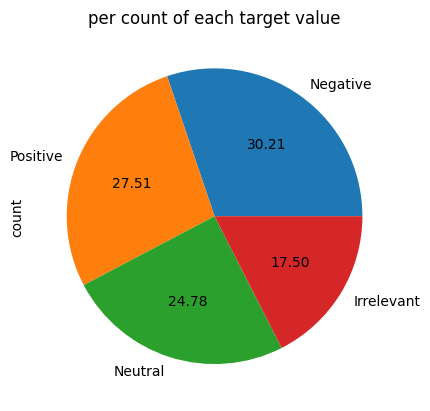

In [47]:
final_df['target'].value_counts().plot(kind='pie',autopct='%.2f')
plt.title("per count of each target value")
plt.show()

In [48]:
target_count = final_df['target'].value_counts().reset_index()
target_count

,target,count
0,Negative,21790
1,Positive,19846
2,Neutral,17879
3,Irrelevant,12624


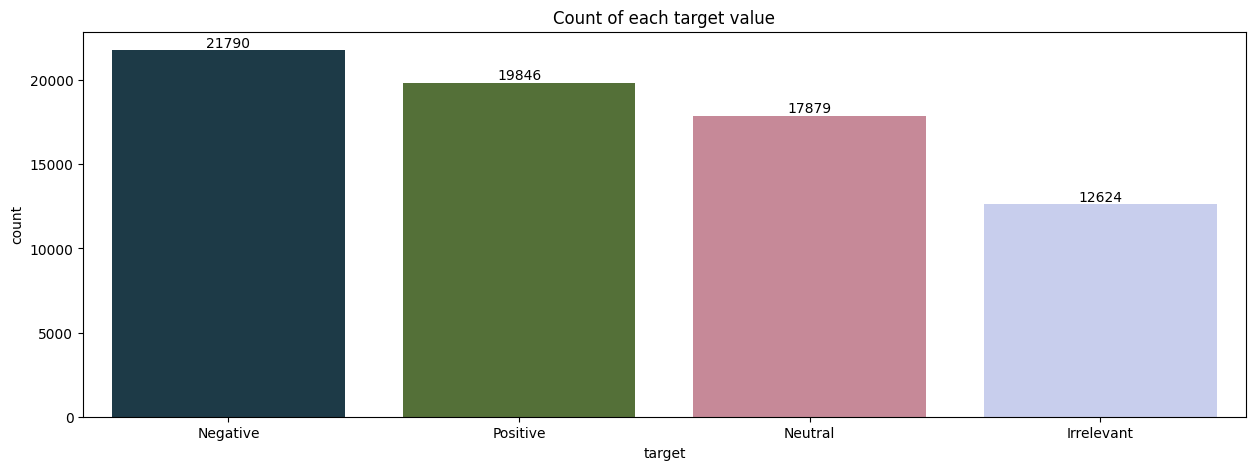

In [49]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=target_count,x='target',y='count',palette='cubehelix')
for bars in ax.containers:
    ax.bar_label(bars)

plt.title("Count of each target value")
plt.show()

In [50]:
# tweet count of each user
tweet_count = final_df.groupby('tweetid')['target'].count().sort_values(ascending=False).reset_index()
tweet_count = tweet_count.rename(columns={'target':'count'})
tweet_count

,tweetid,count
0,8371,7
1,8846,7
2,2752,7
3,10429,7
4,2131,7
...,...,...
12442,4717,2
12443,5647,2
12444,5603,2
12445,3108,2


# feature engineering

In [51]:
# char count
final_df['char_count'] = final_df['content'].apply(len)
# word count
final_df['word_count'] = final_df['content'].apply(lambda x:len(nltk.word_tokenize(x)))
# sentence count
final_df['sent_count'] = final_df['content'].apply(lambda x:len(nltk.sent_tokenize(x)))

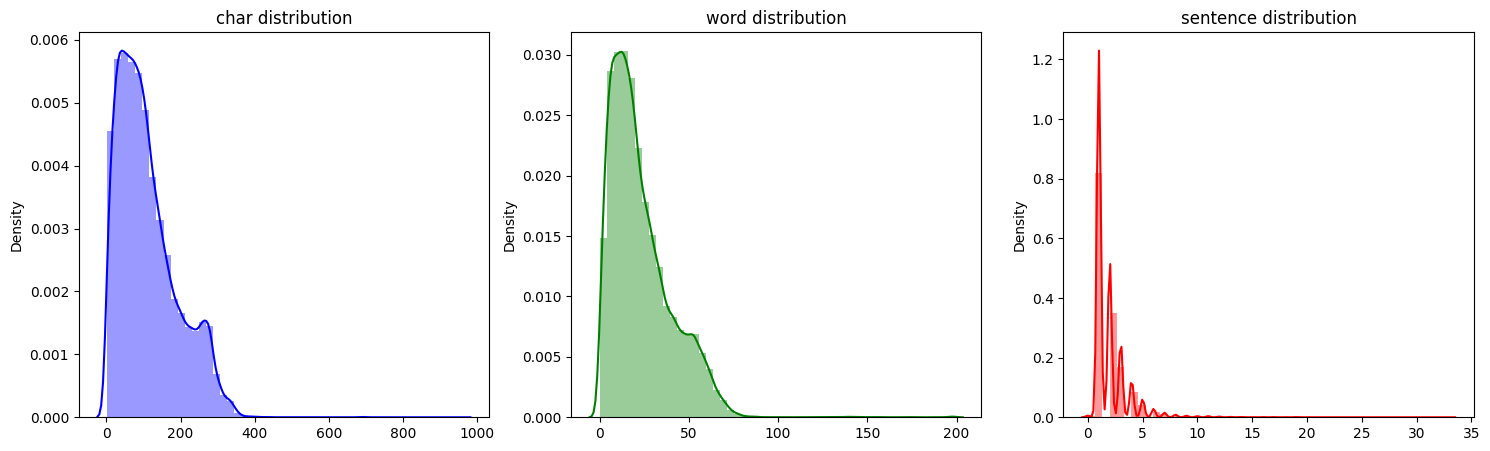

In [52]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
sns.distplot(ax=axes[0],x=final_df['char_count'],color='b')
axes[0].set_title('char distribution')

sns.distplot(ax=axes[1],x=final_df['word_count'],color='g')
axes[1].set_title('word distribution')

sns.distplot(ax=axes[2],x=final_df['sent_count'],color='r')
axes[2].set_title('sentence distribution')
plt.show()

In [54]:
final_df = final_df.drop(columns=['tweetid','entity'],axis=1)

In [55]:
final_df.head()

,target,content,char_count,word_count,sent_count
0,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


In [56]:
final_df['content'] = final_df['content'].apply(lambda x: emoji.replace_emoji(x,replace=''))

# Text Preprocessing

In [57]:
# function for text preprocessing
ps = PorterStemmer()

def preprocessing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    full_txt = []
    for i in text:
        if i not in string.punctuation and i not in stopwords.words('english'):
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)

In [58]:
final_df['content'] = final_df['content'].apply(preprocessing)

In [59]:
final_df.head()

,target,content,char_count,word_count,sent_count
0,Positive,im get borderland murder,53,11,1
1,Positive,come border kill,51,13,1
2,Positive,im get borderland kill,50,11,1
3,Positive,im come borderland murder,51,11,1
4,Positive,im get borderland 2 murder,57,13,1


In [60]:
final_df.duplicated().sum()

2963

In [61]:
final_df = final_df.drop_duplicates()

# EDA

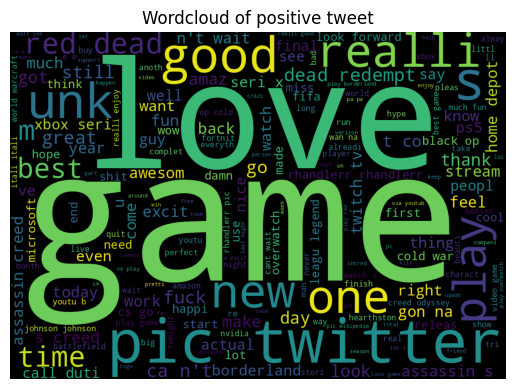

In [62]:
# word cloud for positive tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
positive = wc.generate(final_df[final_df['target']=='Positive']['content'].str.cat(sep=" "))
plt.title('Wordcloud of positive tweet')
plt.axis('off')
plt.imshow(positive)
plt.show()

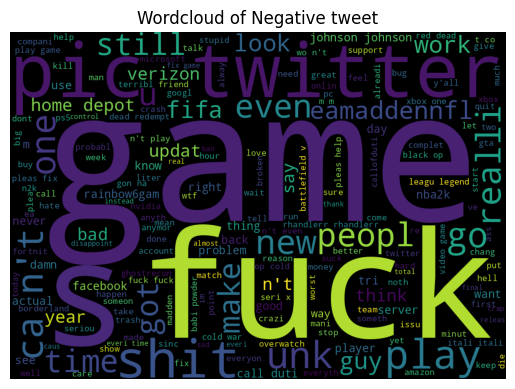

In [63]:
# word cloud for negative tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
negative = wc.generate(final_df[final_df['target']=='Negative']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Negative tweet')
plt.axis('off')
plt.imshow(negative)
plt.show()

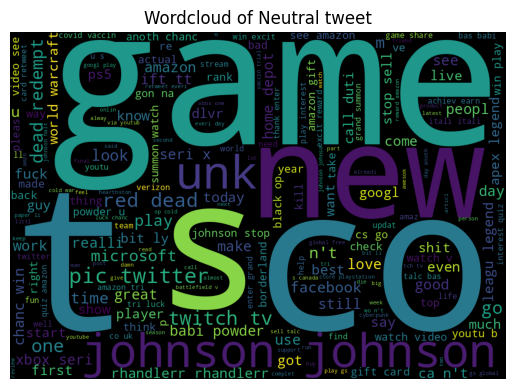

In [64]:
# word cloud for neutral tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
neutral = wc.generate(final_df[final_df['target']=='Neutral']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Neutral tweet')
plt.axis('off')
plt.imshow(neutral)
plt.show()

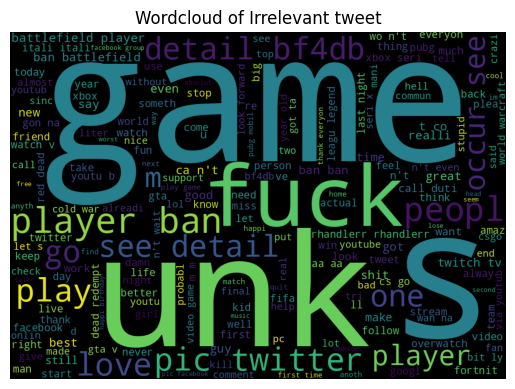

In [65]:
# word cloud for irrelevant tweets
wc = WordCloud(width=1000,height=700,min_font_size=10,background_color='black')
irrelevant = wc.generate(final_df[final_df['target']=='Irrelevant']['content'].str.cat(sep=" "))
plt.title('Wordcloud of Irrelevant tweet')
plt.axis('off')
plt.imshow(irrelevant)
plt.show()

In [66]:
def pre(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    return text

In [67]:
final_df['content'] = final_df['content'].apply(pre)

In [68]:
final_df.duplicated().sum()

156

In [69]:
final_df = final_df.drop_duplicates()

In [70]:
# most common words in positive tweets
positive = []
for txt in final_df[final_df['target']=='Positive']['content'].tolist():
    for word in txt.split():
        positive.append(word)

In [ ]:
len(positive)

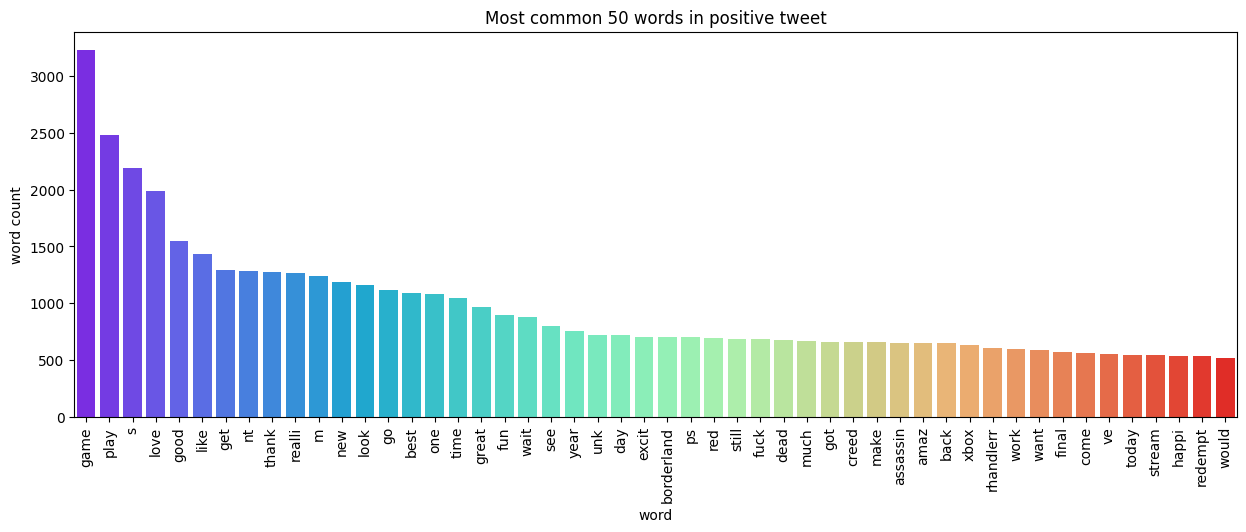

In [71]:
# plot most 50 common words from positive tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(positive).most_common(50))[0],y=pd.DataFrame(Counter(positive).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in positive tweet')
plt.xticks(rotation=90)
plt.show()

In [72]:
# most common words in negative tweets
negative = []
for txt in final_df[final_df['target']=='Negative']['content'].tolist():
    for word in txt.split():
        negative.append(word)

In [73]:
len(negative)

244563

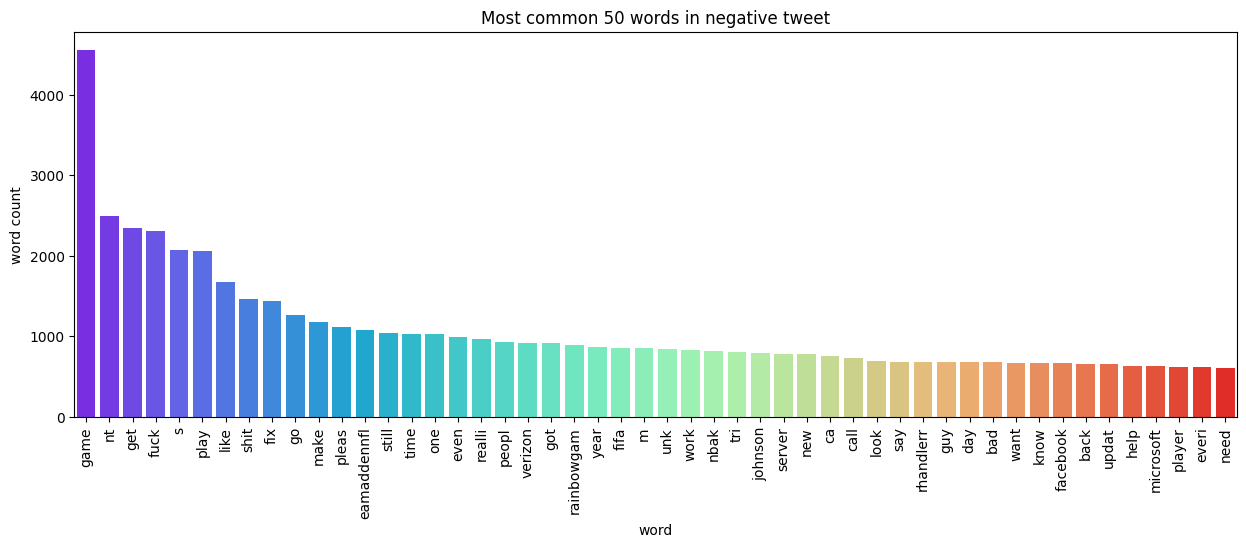

In [74]:
# plot most 50 common words from negative tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(negative).most_common(50))[0],y=pd.DataFrame(Counter(negative).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in negative tweet')
plt.xticks(rotation=90)
plt.show()

In [75]:
# most common words in neutral tweets
neutral = []
for txt in final_df[final_df['target']=='Neutral']['content'].tolist():
    for word in txt.split():
        neutral.append(word)

In [76]:
len(neutral)

210002

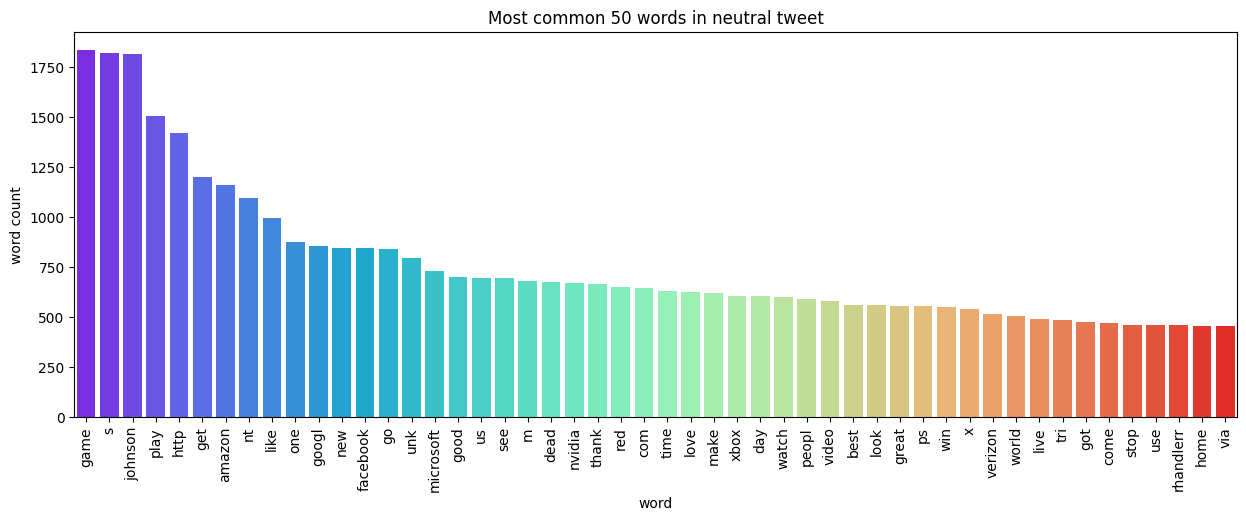

In [77]:
# plot most 50 common words from neutral tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(neutral).most_common(50))[0],y=pd.DataFrame(Counter(neutral).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in neutral tweet')
plt.xticks(rotation=90)
plt.show()


In [78]:
# most common words in irrelevant tweets
irrelevant = []
for txt in final_df[final_df['target']=='Irrelevant']['content'].tolist():
    for word in txt.split():
        irrelevant.append(word)

In [79]:
len(irrelevant)

138683

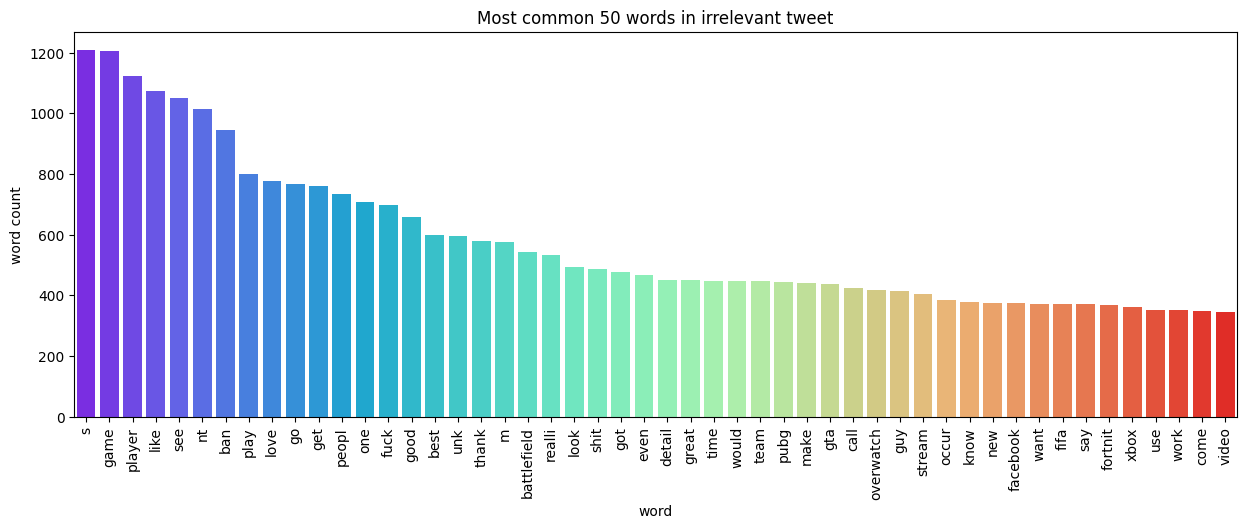

In [80]:
# plot most 50 common words from irrelevant tweets
plt.figure(figsize=(15,5))
sns.barplot(x=pd.DataFrame(Counter(irrelevant).most_common(50))[0],y=pd.DataFrame(Counter(irrelevant).most_common(50))[1],palette='rainbow')
plt.xlabel('word')
plt.ylabel('word count')
plt.title('Most common 50 words in irrelevant tweet')
plt.xticks(rotation=90)
plt.show()